In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from tqdm import tqdm

In [2]:
from ORF_package.orf_package import *

# Data for ORF aniso figures

In [3]:
#ORF_full_num_healpy?

In [4]:
nside = 256
directional = True

In [5]:
%time _, aniso_ORF_HL_10 = ORF_full_num_healpy(f=10, u1=u_H, v1=v_H, u2=u_L, v2=v_L, L1 = L_H, L2=L_L, x1 = x_H, x2=x_L, beta = np.pi/2, nside = nside, directional = directional)
#%time _, aniso_ORF_HL_25 = ORF_full_num_healpy(f=25, u1=u_H, v1=v_H, u2=u_L, v2=v_L, L1 = L_H, L2=L_L, x1 = x_H, x2=x_L, beta = np.pi/2, nside = nside, directional = directional)
#%time _, aniso_ORF_HL_1726 = ORF_full_num_healpy(f=1726, u1=u_H, v1=v_H, u2=u_L, v2=v_L, L1 = L_H, L2=L_L, x1 = x_H, x2=x_L, beta = np.pi/2, nside = nside, directional = directional)
%time _, aniso_ORF_HL_2000 = ORF_full_num_healpy(f=2000, u1=u_H, v1=v_H, u2=u_L, v2=v_L, L1 = L_H, L2=L_L, x1 = x_H, x2=x_L, beta = np.pi/2, nside = nside, directional = directional)

CPU times: user 2.75 s, sys: 4.81 s, total: 7.55 s
Wall time: 7.59 s
CPU times: user 2.24 s, sys: 3.08 s, total: 5.32 s
Wall time: 4.77 s


/home/delillo/.local/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/delillo/.local/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/delillo/.local/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a reg

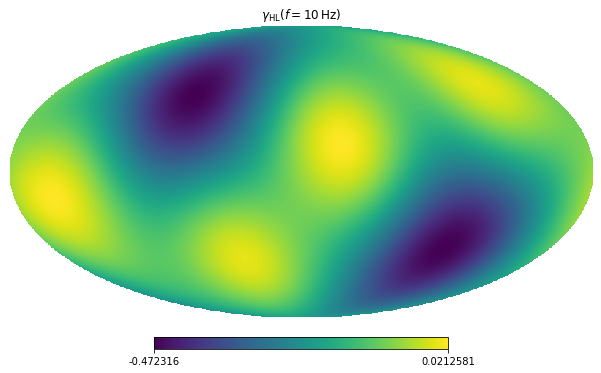

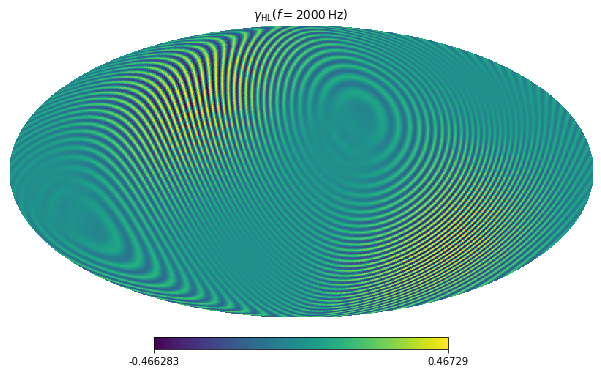

In [6]:
hp.mollview(np.real(aniso_ORF_HL_10), title = r"$\gamma_{\rm HL}(f=10\, {\rm Hz})$")
#hp.mollview(np.real(aniso_ORF_HL_25), title = r"$\gamma_{\rm HL}(f=25\, {\rm Hz})$")
#hp.mollview(np.real(aniso_ORF_HL_1726), title = r"$\gamma_{\rm HL}(f=1726\, {\rm Hz})$")
hp.mollview(np.real(aniso_ORF_HL_2000), title = r"$\gamma_{\rm HL}(f=2000\, {\rm Hz})$")

In [7]:
np.savez(f"./aniso_ORF_HL_single_freqs_nside{nside}.npz", aniso_ORF_HL_10 = aniso_ORF_HL_10, aniso_ORF_HL_2000 = aniso_ORF_HL_2000, nside = nside)
del aniso_ORF_HL_10, aniso_ORF_HL_2000, nside, directional

# Data for point-spread function figures

In [8]:
def vector_earth_rotation(x0, t, t0 = 0):
    try:
        t = np.array(t)
        rot_matrix = [[np.cos(Om_Earth*(np.array(t)-t0)), np.sin(Om_Earth*(t-t0)), np.zeros(len(t))],\
                     [-np.sin(Om_Earth*(t-t0)), np.cos(Om_Earth*(t-t0)), np.zeros(len(t))],\
                     [np.zeros(len(t)), np.zeros(len(t)), np.ones(len(t))]]
        return np.einsum("ij..., j", np.transpose(rot_matrix, axes =(1,0,2)), x0)
    except TypeError:
        rot_matrix = [[np.cos(Om_Earth*(t-t0)), np.sin(Om_Earth*(t-t0)), 0.],\
                     [-np.sin(Om_Earth*(t-t0)), np.cos(Om_Earth*(t-t0)), 0.],\
                     [0., 0., 1.]]
        return np.einsum("ij, j", np.transpose(rot_matrix), x0)

In [9]:
def time_delay(x1 = x_H, x2 = x_L, nside = 8, t=0, t0=0):
    theta, phi = hp.pix2ang(nside, range(0, hp.nside2npix(nside)))
    #print(np.shape( n_hat(theta, phi)), np.shape(vector_earth_rotation(x1-x2, t, t0 = 0)))
    return np.einsum("...k,kj", vector_earth_rotation(x1-x2, t, t0), n_hat(theta, phi))/c
                     
def simple_fisher(x1 = x_H, x2 = x_L, t=0, f = 1, nside = 8, t0=0):
    theta, phi = hp.pix2ang(nside, range(0, int(12*nside**2)))
    orf = np.exp(-2*np.pi*1j*f*np.einsum("...k,kj", vector_earth_rotation(x1-x2, t, t0), n_hat(theta, phi))/c)
    #orf2 = np.exp(-2*np.pi*1j*f*np.einsum("...k,kj", vector_earth_rotation(x1-x2, t, t0), n_hat(theta, phi))/c)
    #print(np.shape(orf))
    fisher_t = np.einsum("...i,...j",np.conjugate(orf), orf)
    if np.shape(fisher_t)[0]!= hp.nside2npix(nside):
        fisher_t = np.sum(fisher_t, axis = 0)
    return fisher_t

def simple_dirty_injection(x1 = x_H, x2 = x_L, t=0, f = 1, nside = 8, t0=0, injection = None):
    #print(f)
    theta, phi = hp.pix2ang(nside, range(0, int(12*nside**2)))
    orf = np.exp(-2*np.pi*1j*f*np.einsum("...k,kj", vector_earth_rotation(x1-x2, t, t0), n_hat(theta, phi))/c)
    #orf2 = np.exp(-2*np.pi*1j*f*np.einsum("...k,kj", vector_earth_rotation(x1-x2, t, t0), n_hat(theta, phi))/c)
    dirty_t = np.einsum("...i,...j, j",np.conjugate(orf), orf, injection)
    if np.shape(dirty_t)[0]!= hp.nside2npix(nside):
        dirty_t = np.sum(dirty_t, axis = 0)
    return dirty_t   

In [10]:
from numba import jit, njit, prange

@njit
def simple_fisher_numba_single_time_delay(orf = [0], orf_star = [0]):
    #Numpy beats this
    """
    Time delay is a sky map of orf with shape (12*nside**2)
    """
    fisher = [[0.+0.j for i in range(len(orf))] for j in range(len(orf_star))]
    for i in range(0, len(orf_star)):
        for j in range(0, len(orf)):
            #print(fisher[i][j], orf_star[j]*orf[i])
            fisher[i][j] = orf_star[i]*orf[j]
            #print(fisher[i][j])
        #return fisher
    return fisher

@njit
def simple_fisher_numba_multiple_time_delay(orf = [0. +0.j], orf_star = [0.+0.j]):
    #This push memory issue to higher nside 
    #It seems to outperform numpy, but difference in the imaginary part!
    """
    Time delay is a sky map of orf with shape (ntimes, 12*nside**2)
    """
    fisher = [[0.+0.j for i in range(len(orf[0]))] for j in range(len(orf_star[0]))]
    #print(np.shape(fisher))
    for t in range(0, len(orf_star)):
        for i in range(0, len(orf[t])):
            for j in range(0, len(orf[t])):
                fisher[i][j] += orf_star[t][i]*orf[t][j]
    return fisher

@njit(parallel = True)
def simple_fisher_numba_multiple_time_delay_prange(orf = [0. +0.j], orf_star = [0.+0.j]):
    #This push memory issue to higher nside 
    #It seems to outperform numpy, but difference in the imaginary part!
    """
    Time delay is a sky map of orf with shape (ntimes, 12*nside**2)
    """
    fisher = [[0.+0.j for i in range(len(orf[0]))] for j in range(len(orf_star[0]))]
    #print(np.shape(fisher))
    for t in prange(0, len(orf_star)):
        for i in range(0, len(orf[t])):
            for j in range(0, len(orf[t])):
                fisher[i][j] += orf_star[t][i]*orf[t][j]
    return fisher

@njit
def simple_fisher_numba_multiple_time_delay_generator(orf = [0. +0.j], orf_star = [0.+0.j]):
    #This push memory issue to higher nside 
    #It seems to outperform numpy, but difference in the imaginary part!
    """
    Time delay is a sky map of orf with shape (ntimes, 12*nside**2)
    """
    
    #print(np.shape(fisher))
    for i in range(0, len(orf[0])):
        for j in range(0, len(orf[0])):
            fisher = 0.+0.j
            for t in range(0, len(orf_star)):
                fisher += orf_star[t][i]*orf[t][j]
            yield fisher

## Ideal ORFs

### Warmup

In [11]:
nside=1
f = 100
freqs = np.logspace(0,3, 4)
times = np.arange(0, day_s, 3600)
theta, phi = hp.pix2ang(nside, range(0, int(12*nside**2)))

In [12]:
#(-2*np.pi*1j*f*np.einsum("...k,kj", vector_earth_rotation(x_H-x_L, t=times, t0=0), n_hat(theta, phi))/c)
time_delay_seeds = -2*np.pi*1j*time_delay(x1 = x_H, x2 = x_L, nside = nside, t=times, t0=0)
orf_HL= np.array([np.exp(f*time_delay_seeds) for f in freqs])
#orf = np.array([np.exp(-2*np.pi*1j*f*np.einsum("...k,kj", vector_earth_rotation(x_H-x_L, t=times, t0=0), n_hat(theta, phi))/c) for f in freqs])

In [13]:
orf_HL = orf_HL.reshape(-1, *orf_HL.shape[-1:])
%time fisher_simple_HL=simple_fisher_numba_multiple_time_delay(orf = list(orf_HL), orf_star = list(np.conjugate(orf_HL)))

/home/delillo/.local/lib/python3.8/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'orf' of function 'simple_fisher_numba_multiple_time_delay'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-10-bfc3cc393de8>", line 19:
@njit
def simple_fisher_numba_multiple_time_delay(orf = [0. +0.j], orf_star = [0.+0.j]):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/delillo/.local/lib/python3.8/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'orf_star' of function 'simple_fisher_numba_multiple_time_delay'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.htm

CPU times: user 952 ms, sys: 21.1 ms, total: 973 ms
Wall time: 971 ms


In [14]:
%time fisher_simple_HL=simple_fisher_numba_multiple_time_delay(orf = list(orf_HL), orf_star = list(np.conjugate(orf_HL)))
%time fisher_simple_HL_from_generator=simple_fisher_numba_multiple_time_delay_generator(orf = list(orf_HL), orf_star = list(np.conjugate(orf_HL)))

CPU times: user 5.47 ms, sys: 0 ns, total: 5.47 ms
Wall time: 5.3 ms


/home/delillo/.local/lib/python3.8/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'orf' of function 'simple_fisher_numba_multiple_time_delay_generator'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-10-bfc3cc393de8>", line 49:
@njit
def simple_fisher_numba_multiple_time_delay_generator(orf = [0. +0.j], orf_star = [0.+0.j]):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/delillo/.local/lib/python3.8/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'orf_star' of function 'simple_fisher_numba_multiple_time_delay_generator'.

For more information visit https://numba.readthedocs.io/en/st

CPU times: user 656 ms, sys: 3.34 ms, total: 660 ms
Wall time: 657 ms


In [15]:
intensity = 1
source = np.zeros(np.shape(theta))
#print(np.pi/2,theta[theta<np.pi/2])
if nside<32:
    source[(np.abs(theta)<np.pi/2) &(theta>np.pi/2-0.1) & (phi==0.)]=intensity #ok for nside >8
#source[(np.abs(theta)<np.pi/2) &(theta>np.pi/2-0.2) & (phi==0.)]=intensity #ok for nside <=8
else:
    source[(np.abs(theta)<np.pi/2) &(theta>np.pi/2-0.05) & (phi==0.)]=intensity #ok for nside >32
#print(source[source ==intensity])

In [16]:
%time test_simple_dirty_injection = np.einsum("ij, j", fisher_simple_HL, source)

CPU times: user 44 µs, sys: 41 µs, total: 85 µs
Wall time: 88 µs


### Run with compiled function

In [26]:
nside=32
f = 100
freqs = np.logspace(0,3, 100)
times = [0]#np.arange(0, day_s, 3600)
theta, phi = hp.pix2ang(nside, range(0, int(12*nside**2)))

In [27]:
time_delay_seeds = -2*np.pi*1j*time_delay(x1 = x_H, x2 = x_L, nside = nside, t=times, t0=0)
orf_HL= np.array([np.exp(f*time_delay_seeds) for f in freqs])

In [28]:
orf_HL = orf_HL.reshape(-1, *orf_HL.shape[-1:])
#%time fisher_simple_HL=simple_fisher_numba_multiple_time_delay(orf = list(orf_HL), orf_star = list(np.conjugate(orf_HL)))

In [29]:
intensity = 1
source = np.zeros(np.shape(theta))
#print(np.pi/2,theta[theta<np.pi/2])
if nside<32:
    source[(np.abs(theta)<np.pi/2) &(theta>np.pi/2-0.1) & (phi==0.)]=intensity #ok for nside >8
#source[(np.abs(theta)<np.pi/2) &(theta>np.pi/2-0.2) & (phi==0.)]=intensity #ok for nside <=8
else:
    source[(np.abs(theta)<np.pi/2) &(theta>np.pi/2-0.05) & (phi==0.)]=intensity #ok for nside >32
#print(source[source ==intensity])

In [30]:
#%time HL_simple_dirty_injection = np.einsum("ij, j", fisher_simple_HL, source)

In [31]:
#hp.mollview(np.real(HL_simple_dirty_injection))

#### With generator

In [32]:
%time fisher_simple_HL_from_generator=simple_fisher_numba_multiple_time_delay_generator(orf = list(orf_HL), orf_star = list(np.conjugate(orf_HL)))

CPU times: user 15.4 ms, sys: 11.7 ms, total: 27 ms
Wall time: 34.6 ms


In [33]:
%time fisher_simple_HL_from_generator= np.reshape(list(fisher_simple_HL_from_generator), (12*nside**2, 12*nside**2))

CPU times: user 3min 23s, sys: 7.93 s, total: 3min 31s
Wall time: 3min 29s


CPU times: user 1.05 s, sys: 0 ns, total: 1.05 s
Wall time: 1.05 s


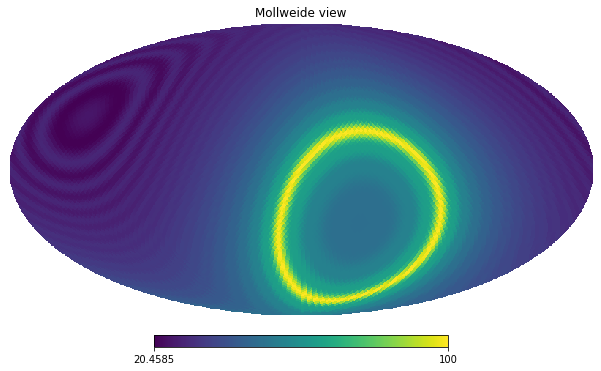

In [34]:
%time HL_simple_dirty_injection_from_generator = np.einsum("ij, j", fisher_simple_HL_from_generator, source)
hp.mollview(np.real(HL_simple_dirty_injection_from_generator))

In [36]:
np.savez("./HL_ideal_teardrop_nside32_dirty_map_1_1000_single_time.npz", HL_ideal_teardrop_nside32_dirty_map = HL_simple_dirty_injection_from_generator)

#### Single frequency

In [37]:
nside=32
f = 100
freqs = [375]#np.logspace(0,3, 100)
times = [0]#np.arange(0, day_s, 3600)
theta, phi = hp.pix2ang(nside, range(0, int(12*nside**2)))

In [38]:
time_delay_seeds = -2*np.pi*1j*time_delay(x1 = x_H, x2 = x_L, nside = nside, t=times, t0=0)
orf_HL= np.array([np.exp(f*time_delay_seeds) for f in freqs])

In [39]:
orf_HL = orf_HL.reshape(-1, *orf_HL.shape[-1:])
#%time fisher_simple_HL=simple_fisher_numba_multiple_time_delay(orf = list(orf_HL), orf_star = list(np.conjugate(orf_HL)))

In [40]:
%time fisher_simple_HL_from_generator=simple_fisher_numba_multiple_time_delay_generator(orf = list(orf_HL), orf_star = list(np.conjugate(orf_HL)))

CPU times: user 2.25 ms, sys: 24.3 ms, total: 26.5 ms
Wall time: 31.9 ms


In [41]:
%time fisher_simple_HL_from_generator= np.reshape(list(fisher_simple_HL_from_generator), (12*nside**2, 12*nside**2))

CPU times: user 35.4 s, sys: 6.98 s, total: 42.4 s
Wall time: 42.6 s


CPU times: user 875 ms, sys: 3.35 ms, total: 879 ms
Wall time: 877 ms


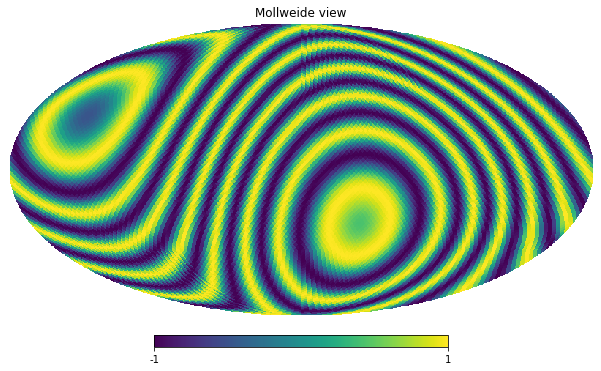

In [42]:
%time HL_simple_dirty_injection_from_generator = np.einsum("ij, j", fisher_simple_HL_from_generator, source)
hp.mollview(np.real(HL_simple_dirty_injection_from_generator))

In [44]:
nside=32
f = 100
freqs = [375]#np.logspace(0,3, 100)
times = np.arange(0, day_s, 3600)
theta, phi = hp.pix2ang(nside, range(0, int(12*nside**2)))

In [45]:
time_delay_seeds = -2*np.pi*1j*time_delay(x1 = x_H, x2 = x_L, nside = nside, t=times, t0=0)
orf_HL= np.array([np.exp(f*time_delay_seeds) for f in freqs])

In [46]:
orf_HL = orf_HL.reshape(-1, *orf_HL.shape[-1:])
#%time fisher_simple_HL=simple_fisher_numba_multiple_time_delay(orf = list(orf_HL), orf_star = list(np.conjugate(orf_HL)))

In [47]:
%time fisher_simple_HL_from_generator=simple_fisher_numba_multiple_time_delay_generator(orf = list(orf_HL), orf_star = list(np.conjugate(orf_HL)))

CPU times: user 3.62 ms, sys: 205 ms, total: 209 ms
Wall time: 206 ms


In [48]:
%time fisher_simple_HL_from_generator= np.reshape(list(fisher_simple_HL_from_generator), (12*nside**2, 12*nside**2))

CPU times: user 1min 7s, sys: 6.63 s, total: 1min 13s
Wall time: 1min 13s


CPU times: user 1.09 s, sys: 64 µs, total: 1.09 s
Wall time: 1.09 s


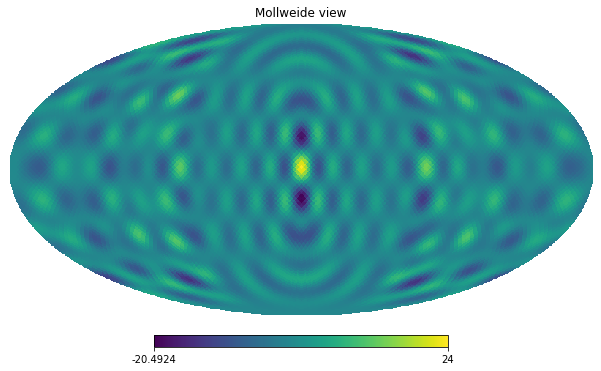

In [49]:
%time HL_simple_dirty_injection_from_generator = np.einsum("ij, j", fisher_simple_HL_from_generator, source)
hp.mollview(np.real(HL_simple_dirty_injection_from_generator))

In [50]:
np.savez("./HL_ideal_teardrop_nside32_dirty_map_375_over_time.npz", HL_ideal_teardrop_nside32_dirty_map = HL_simple_dirty_injection_from_generator)